In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gdown

from scipy import sparse

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

import optuna
from joblib import dump, load


In [71]:
#gdown.download_folder("https://drive.google.com/drive/folders/1-Alb_OJs3KC4eSrJaf33bOBBWOm1sdRI?usp=drive_link", quiet=True)

In [72]:
#!gzip -d -f 5/*.gz

# 1. Eksploracja (7 pkt.)

In [73]:
X = pd.read_csv('5/X_train.csv').astype('float32')
X.head()

,LINC01128,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,UBE2J2,...,MT-CO1,MT-ATP8,MT-ATP6,MT-ND3,MT-ND4,MT-ND6,MT-CYB,AC011043.1,AL592183.1,AC240274.1
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,3.416833,0.000000,3.743885,3.416833,3.743885,0.000000,2.927649,0.0,0.0,0.0
1,0.0,0.0,0.0,1.730041,0.0,0.0,0.000000,0.656575,0.0,0.000000,...,3.591011,0.000000,2.763222,3.020021,3.186535,0.000000,2.014535,0.0,0.0,0.0
2,0.0,0.0,0.0,0.772655,0.0,0.0,0.772655,0.000000,0.0,0.000000,...,3.443720,1.203277,3.732723,3.813070,3.237723,1.203277,3.325276,0.0,0.0,0.0
3,0.0,0.0,0.0,0.782342,0.0,0.0,0.000000,0.000000,0.0,0.782342,...,3.461077,1.215854,3.208088,3.254951,3.383647,0.000000,2.094271,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,2.747173,0.714296,2.984138,2.436021,2.677984,0.714296,2.436021,0.0,0.0,0.0


In [74]:
y = pd.read_csv('5/y_train.csv').set_index("Id").astype('float32')
y.head()

,Expected
Id,
0,1.079152
1,2.445027
2,0.000000
3,2.082076
4,2.012017


In [75]:
X_task = pd.read_csv('5/X_test.csv').astype('float32')
X_task.head()

,LINC01128,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,UBE2J2,...,MT-CO1,MT-ATP8,MT-ATP6,MT-ND3,MT-ND4,MT-ND6,MT-CYB,AC011043.1,AL592183.1,AC240274.1
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.565192,...,3.720102,0.924088,3.169415,3.317543,2.454189,0.000000,2.386670,0.0,0.0,0.0
1,0.0,0.0,0.0,0.973258,0.973258,0.0,0.973258,0.0,0.0,0.000000,...,3.180208,0.000000,2.527797,2.222759,2.651299,0.000000,1.781652,0.0,0.0,0.0
2,0.0,0.0,0.0,1.055984,0.000000,0.0,1.055984,0.0,0.0,0.000000,...,2.647848,1.558061,3.786924,3.433885,2.772490,1.055984,2.883304,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,2.956841,1.536313,3.879840,3.952472,3.278350,0.000000,3.521253,0.0,0.0,0.0
4,0.0,0.0,0.0,1.132702,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,2.938329,0.000000,3.267604,3.092873,2.242424,0.000000,2.123950,0.0,0.0,0.0


## (a)
Sprawdź, ile obserwacji i zmiennych zawierają wczytane dane treningowe oraz testowe. Przyjrzyj się typom zmiennych i, jeśli uznasz to za słuszne, dokonaj odpowiedniej konwersji przed dalszą analizą. Upewnij się, czy dane są kompletne.

In [76]:
print("X data shape:", X.shape)
print("y data shape:", y.shape)
print("X_task data shape:", X_task.shape)

X data shape: (3794, 9228)
y data shape: (3794, 1)
X_task data shape: (670, 9228)


**Analiza ilości obserwacji i zmiennych:**
- X_train zawiera 3794 obserwacje i 9228 zmiennych.
- y_train zawiera 3794 obserwacje i 1 zmienną.
- X_test zawiera 670 obserwacji i 9228 zmiennych.

In [77]:
print(X.info(),"\n")
print(y.info(),"\n")
print(X_task.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9228 entries, LINC01128 to AC240274.1
dtypes: float32(9228)
memory usage: 133.6 MB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 3794 entries, 0 to 3793
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Expected  3794 non-null   float32
dtypes: float32(1)
memory usage: 44.5 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9228 entries, LINC01128 to AC240274.1
dtypes: float32(9228)
memory usage: 23.6 MB
None 



Wszystkie zmienne zostały już przekształcone do optymalnego formatu float32. Dodatkowo, stwierdzono, że zarówno zbiory danych treningowych, jak i testowych są w pełni kompletne, co oznacza brak jakichkolwiek brakujących wartości (NULL). Dodatkowo nalezy sprawdzić, czy nie występują zadne zmienne z samymi zerowymi wartościami.

In [78]:
print((X == 0).all(axis=0).sum())
print((y == 0).all(axis=0).sum())
print((X_task == 0).all(axis=0).sum())

228
0
345


Uzyskano następujące wnioski:
- Dla X_train znaleziono 228 kolumn, w których wszystkie wartości są równe 0.
- Dla y_train nie znaleziono żadnej kolumny, w której wszystkie wartości są równe 0, co jest oczekiwanym wynikiem, ponieważ y_train reprezentuje wektor wartości docelowych.
- Dla X_test znaleziono 345 kolumn, w których wszystkie wartości są równe 0.

In [79]:
columns_to_remove = X.columns[(X == 0).all(axis=0)]
X = X.drop(columns=columns_to_remove)
X_task = X_task.drop(columns=columns_to_remove)

W ten sposób, dokonałem usunięcia tych kolumn z zestawów danych treningowych (X_train) i testowych (X_test), które zawierają wyłącznie wartości zerowe dla wszystkich obserwacji dla zestawu danych treningowych (X_train). Kolumny te nie wniosłyby zadnej wartości do modelu predykcyjnego.

## (b)
Zbadaj rozkład empiryczny zmiennej objaśnianej (przedstaw kilka podstawowych statystyk,
do analizy dołącz histogram lub wykres estymatora gęstości).

In [80]:
y['Expected'].describe()

count    3794.000000
mean        0.770766
std         0.926976
min         0.000000
25%         0.000000
50%         0.249925
75%         1.794385
max         3.088281
Name: Expected, dtype: float64

Wnioski:
-  Średnia: Wartość średnia wynosi około 0.770766

- Odchylenie standardowe: Odchylenie standardowe wynoszące około 0.926976 wskazuje na pewną zmienność w danych, ale nie jest ona ekstremalnie wysoka.

- Mediana: Mediana na poziomie 0.249925 sugeruje, że połowa obserwacji ma wartość zmiennej Expected mniejszą niż 0.25.

In [81]:
fig = px.histogram(y, x='Expected', nbins=50, title='Histogram zmiennej objaśnianej')
fig.update_layout(xaxis_title='Wartość zmiennej objaśnianej', yaxis_title='Liczba obserwacji')
fig.show()

Wnioski:
- Duża liczba wartości równych 0 - Wskazuje to na skupienie dużej liczby obserwacji wokół wartości minimalnej.

- Peak dla wartości około 0.3 - Występowanie lokalnego maksimum w okolicach wartości 0.3 może wskazywać na to, że oprócz dużej liczby wartości bliskich 0, istnieje również znacząca liczba obserwacji skupionych wokół tej wartości.

- Drugi peak dla wartości około 2.2: Kolejne lokalne maksimum w okolicach wartości 2.2 sugeruje, że istnieje jeszcze jedna grupa obserwacji, która skupia się wokół tej wartości.

## (c)
Wybierz 250 zmiennych objaśniających najbardziej skorelowanych ze zmienną objaśnianą. Policz korelację dla każdej z par tych zmiennych. Zilustruj wynik za pomocą mapy ciepła (heatmap).

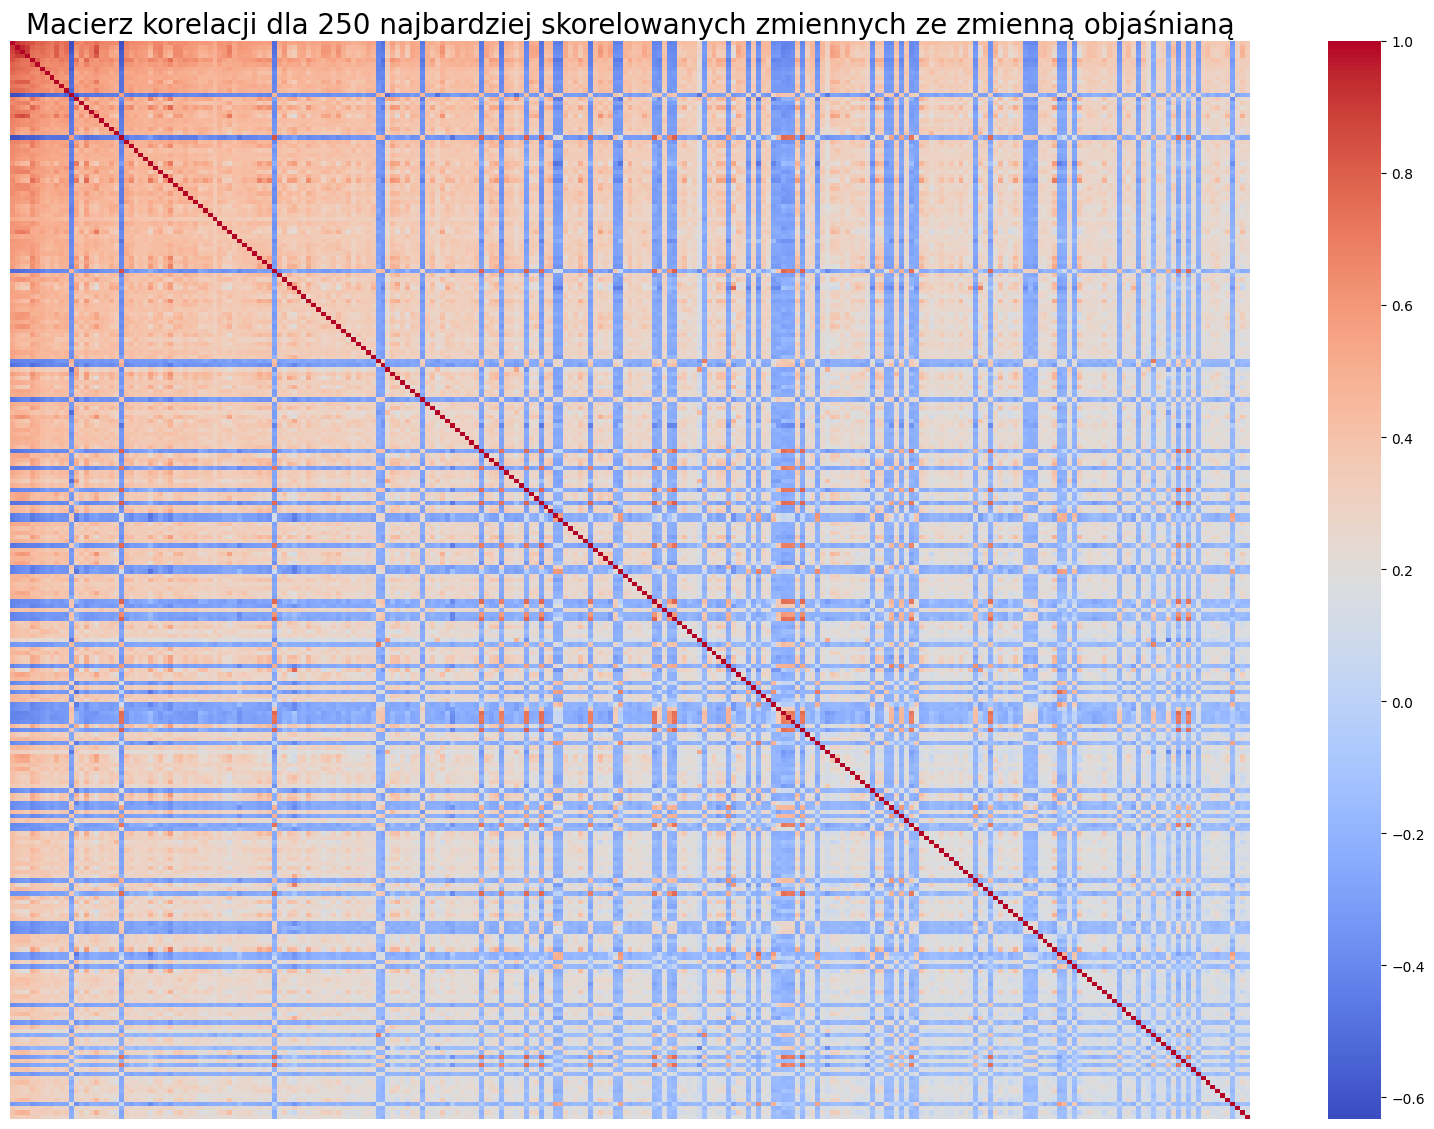

In [82]:
correlations = X.corrwith(y['Expected'])
top_correlated_variables = correlations.abs().nlargest(251).index
top_variables = X[top_correlated_variables]
correlation_matrix = top_variables.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, xticklabels=False, yticklabels=False)
plt.title('Macierz korelacji dla 250 najbardziej skorelowanych zmiennych ze zmienną objaśnianą', fontsize=20)
plt.show()

Na podstawie macierzy korelacji dla 250 najbardziej skorelowanych zmiennych ze zmienną objaśnianą zauwazono, ze w niektórych obszarach występuje wysoka korelacja między zmiennymi. Oznacza to, ze zmienne niosą podobne informacje, co przy budowie modeli predykcyjnych moze być problemem. 

# 2. ElasticNet (7 pkt.)
Pierwszy model, który należy wytrenować, to ElasticNet. Którego szczególne przypadki stanowią
regresja grzbietowa (ridge regression) oraz lasso.

## (a)
Przedstaw w raporcie informacje o modelu ElasticNet, objaśniając parametry, które są w nim
estymowane, optymalizowaną funkcję oraz hiperparametry, od których ona zależy. Dla jakich
wartości hiperparametrów otrzymujemy regresję grzbietową, a dla jakich lasso?

- ElasticNet - model regresji liniowej, łączący w sobie cechy regresji Lasso i cechy regresji Ridge.

**Parametry estymowane w modelu ElasticNet:**
- Wagi (coefficients): Współczynniki przy zmiennych, które minimalizują funkcję kosztu.

- Współczynnik przesunięcia (intercept): Stała wartość dodawana do przewidywanych wartości.



**Optymalizowana funkcja:**

- ElasticNet optymalizuje funkcję kosztu, która jest sumą RSS (residual sum of squares) oraz dwóch terminów regularizacyjnych: L1 i L2:

$$ L(\beta) = \frac{1}{2 n} \|y - X\beta|_2^2 
+ \alpha \cdot l \cdot \|\beta\|_1 
+ 0.5 \cdot \alpha \cdot (1 - l) \cdot \|\beta\|_2^2
 $$

- gdzie:

    - ($||\beta||_1$) to suma wartości bezwzględnych współczynników (norma L1),
    - ($||\beta||_2^2$) to suma kwadratów współczynników (norma L2),
    - ($\alpha$) to parametr kontrolujący ogólną siłę regularyzacji,
    - ($l$) to parametr mieszania, który balansuje wpływ regresji Lasso i regresji grzbietowej.

**Hiperparametry Modelu:**

- alpha: Współczynnik regularyzacji.

- l1_ratio: Parametr określający regularyzację L1 w stosunku do L2. Jest to wartość z zakresu [0, 1] 

$$ alpha = \lambda_1 + \lambda_2$$
$$ \text{l1\_ratio} = \lambda_1 / (\lambda_1 + \lambda_2) $$

**Regresja Grzbietowa a LASSO:** 

- Regresję Grzbietową otrzymujemy gdy l1_ratio = 0.

- Regresję LASSO otrzymujemy gdy l1_ratio = 1.


## (b)
Zdefiniuj siatkę (grid) hiperparametrów, opartą na co najmniej trzech wartościach każdego
z hiperparametrów. Zadbaj o to, by w siatce znalazły się konfiguracje hiperparametrów odpowiadające regresji grzbietowej i lasso. Użyj walidacji krzyżowej do wybrania odpowiednich hiperparametrów (o liczbie podzbiorów użytych w walidacji krzyżowej należy zdecydować samodzielnie oraz uzasadnić swój wybór).

In [ ]:
y = y['Expected'].to_numpy()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=54)

Ze względu na duzy zbiór danych wybrano liczbe podziobór cv=5 uzytych w walidacji krzyzowej.

W celu znalezienia najlepszych hiperparametrów dla modelu ElasticNet, wykorzystano GridSearchCV. Stworzono pipeline składający się z trzech kroków: sparsifier - zamienia dane na rzadką macierz, scaler - standaryzuje dane, elastic_net - model.

In [ ]:
pipeline_elasticnet = Pipeline([
    ('sparsifier', FunctionTransformer(sparse.csc_matrix, accept_sparse=True)),
    ('scaler', StandardScaler(with_mean=False)),
    ('elastic_net', ElasticNet(random_state=42))
])

param_grid_elasticnet = {
    'elastic_net__alpha': [0.1, 1, 10],  
    'elastic_net__l1_ratio': [0.0, 0.5, 1.0]  
}

elasticnet_gs = GridSearchCV(estimator=pipeline_elasticnet, 
                             param_grid=param_grid_elasticnet, 
                             cv=kf, scoring='neg_root_mean_squared_error', 
                             n_jobs=-1,
                             verbose=3)

elasticnet_gs.fit(X, y)

dump(elasticnet_gs, 'elasticnet_gs_results.joblib')

In [87]:
elasticnet_gs = load('elasticnet_gs_results.joblib')
best_params_elasticnet = elasticnet_gs.best_params_
print("Najlepsze hiperparametry:", best_params_elasticnet)

Najlepsze hiperparametry: {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.0}


Według tego podstawowego modelu najlepszy wynik otrzymano dla l1 = 0 i alpha = 1. Oznacza to regresję grzbietową (Ridge)

## (c)
Podaj błąd treningowy i walidacyjny modelu (należy uśrednić wynik względem wszystkich
podzbiorów wyróżnionych w walidacji krzyżowej).

In [88]:
mean_cv_score_elasticnet = -elasticnet_gs.best_score_  
std_cv_score_elasticnet = elasticnet_gs.cv_results_['std_test_score'][elasticnet_gs.best_index_]

best_model_elasticnet = elasticnet_gs.best_estimator_
y_pred_elasticnet = best_model_elasticnet.predict(X)
train_error_elasticnet = np.sqrt(np.mean((y - y_pred_elasticnet) ** 2))

print("Średni błąd walidacyjny (RMSE):", mean_cv_score_elasticnet)
print("Odchylenie standardowe błędu walidacyjnego (RMSE):", std_cv_score_elasticnet)
print("Błąd treningowy (RMSE):", train_error_elasticnet)

Średni błąd walidacyjny (RMSE): 0.31694561839103697
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.011518495788344773
Błąd treningowy (RMSE): 0.13467741


# 3. Lasy losowe (8 pkt.)
W tej części projektu należy wytrenować model lasów losowych i porównać jego działanie z utworzonym wcześniej modelem ElasticNet.

## (a)
Spośród wielu hiperparametrów charakteryzujących model lasów losowych wybierz trzy różne. Zdefiniuj trójwymiarową siatkę przeszukiwanych kombinacji hiperparametrów i za pomocą
walidacji krzyżowej wybierz ich optymalne (w kontekście wykonywanej predykcji) wartości.
Wykorzystany przy walidacji krzyżowej podział danych powinien być taki sam, jak w przypadku ElasticNet.

W celu znalezienia najlepszych hiperparametrów dla modelu RandomForestRegressor, równiez wykorzystano technikę GridSearchCV. Określono siatkę hiperparametrów do przeszukiwania dla modelu RandomForestRegressor:

- max_depth: Maksymalna głębokość drzewa decyzyjnego.

- min_samples_split: Minimalna liczba próbek wymagana do podziału węzła.

- n_estimators: Liczba drzew w lesie.

In [ ]:
param_grid_random_forest = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300],
}

randomforest_gs = GridSearchCV(estimator=RandomForestRegressor(max_features='sqrt', random_state=42),
                                param_grid=param_grid_random_forest,
                                cv=kf, scoring='neg_root_mean_squared_error',
                                n_jobs=-1,
                                verbose=3)

randomforest_gs.fit(X, y)
dump(randomforest_gs, 'randomforest_gs_results.joblib')

In [89]:
randomforest_gs = load('randomforest_gs_results.joblib')
best_params_randomforest = randomforest_gs.best_params_
print("Najlepsze hiperparametry:", best_params_randomforest)

Najlepsze hiperparametry: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}


In [90]:
mean_cv_score_randomforest = -randomforest_gs.best_score_  
std_cv_score_randomforest = randomforest_gs.cv_results_['std_test_score'][randomforest_gs.best_index_]

best_model_randomforest = randomforest_gs.best_estimator_
y_pred_randomforest = best_model_randomforest.predict(X)
train_error_randomforest = np.sqrt(np.mean((y - y_pred_randomforest) ** 2))

print("Średni błąd walidacyjny (RMSE):", mean_cv_score_randomforest)
print("Odchylenie standardowe błędu walidacyjnego (RMSE):", std_cv_score_randomforest)
print("Błąd treningowy (RMSE):", train_error_randomforest)

Średni błąd walidacyjny (RMSE): 0.30724643393411394
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.012340737085319518
Błąd treningowy (RMSE): 0.1297624746077744


## (b)
Zrób podsumowanie tabelaryczne wyników, jakie otrzymywały metody w walidacji krzyżowej
w obu rozważanych modelach. (Porównanie to jest powodem, dla którego zależy nam na zastosowaniu tych samych podziałów). Określ, który model wydaje Ci się najlepszy (uzasadnij swój
wybór). Do porównania dołącz podstawowy model referencyjny, który dowolnym wartościom
zmiennych objaśniających przypisuje średnią arytmetyczną zmiennej objaśnianej.

In [91]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X, y)
y_pred_dummy = dummy_regressor.predict(X)
train_error_dummy = np.sqrt(np.mean((y - y_pred_dummy) ** 2))
print("Błąd treningowy (RMSE) Dummy Regressor:", train_error_dummy)

Błąd treningowy (RMSE) Dummy Regressor: 0.92685354


In [92]:
results = {
    'Model': ['ElasticNet', 'RandomForest', 'DummyRegressor'],
    'Mean CV Error (RMSE)': [mean_cv_score_elasticnet, mean_cv_score_randomforest, '-'],
    'Std CV Error (RMSE)': [std_cv_score_elasticnet, std_cv_score_randomforest, '-'],
    'Training Error (RMSE)': [train_error_elasticnet, train_error_randomforest, train_error_dummy],
}

results_df = pd.DataFrame(results)
results_df

,Model,Mean CV Error (RMSE),Std CV Error (RMSE),Training Error (RMSE)
0,ElasticNet,0.316946,0.011518,0.134677
1,RandomForest,0.307246,0.012341,0.129762
2,DummyRegressor,-,-,0.926854


Oba modele, ElasticNet i RandomForest, wykazały się znacznie lepszymi wynikami w porównaniu do DummyRegressor, co potwierdza ich skuteczność. RandomForest osiągnął minimalnie lepsze wyniki niż ElasticNet.

# 4. Predykcja na zbiorze testowym (8 pkt.)
Ta część projektu ma charakter otwarty. W oparciu o dane treningowe należy dopasować dowolnie
wybrany model, a następnie zastosować go do przewidywania wartości zmiennej objaśnianej w
zbiorze testowym. Sposób wyboru i budowy modelu, a także motywacje stojące za takim wyborem
powinny zostać opisane w raporcie. Wygenerowane predykcje należy wysłać do prowadzącego w
osobnym pliku, którego format został opisany wcześniej. Liczba uzyskanych punktów zależeć będzie
od jakości predykcji, mierzonej pierwiastkiem błędu średniokwadratowego, RMSE.
Szczegóły punktacji:
(1 pkt.) – za błąd niższy od pochodzącego z opisanego wcześniej, podstawowego modelu referencyjnego.
(2 pkt.) – za błąd niższy od pochodzącego z modelu ElasticNet wytrenowanego przez prowadzących
laboratoria.
(5 pkt.) – ten bonus obliczany jest według wzoru 1
2
⌊10Fb(e)
3
⌋, gdzie e to błąd testowy predykcji studenta, Fb jest dystrybuantą empiryczną błędów wszystkich zgłoszonych predykcji w grupie
laboratoryjnej studenta, natomiast ⌊·⌋ to część całkowita.

In [105]:
def model_evaluation(model, X_train, y_train, X_test, y_test, kf=5):
    cross_val = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    mean_cv_score = -cross_val.mean()
    std_cv_score = cross_val.std()
    
    y_train_pred = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Cross-validation RMSE: {mean_cv_score:.2f} +/- {std_cv_score:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")


    return mean_cv_score, std_cv_score, rmse_train, rmse_test

Aby usprawić walidacje modelu, otrzymane dane treningowe podzielono na podzbiór treningowy i testowy:

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

In [106]:
kf = KFold(n_splits=5, shuffle=True, random_state=54)

Następnie przeprowadzono optymalizację hiperparametrów dla modelu RandomForestRegressor przy użyciu biblioteki Optuna. Celem było znalezienie kombinacji parametrów, która minimalizuje błąd predykcji na danych walidacyjnych.

In [42]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth, 
                                min_samples_split=min_samples_split, 
                                min_samples_leaf=min_samples_leaf, 
                                n_jobs=-1, 
                                random_state=54, 
                                verbose=1)
    score = cross_val_score(model, 
                            X_train, 
                            y_train, 
                            n_jobs=-1, 
                            cv=kf, 
                            scoring='neg_root_mean_squared_error',
                            verbose=1).mean()

    return score


study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=54))
study_rf.optimize(objective_rf, n_trials=50)
#dump(study_rf, 'optuna_rf.joblib')

Najlepsze wartości hiperparametrów:

In [107]:
study_rf.best_params

{'n_estimators': 979,
 'max_depth': 29,
 'min_samples_split': 11,
 'min_samples_leaf': 6}

In [98]:
optuna.visualization.plot_optimization_history(study_rf)

Dla wybranych parametrów model osiągniął bład RMSE = 0.2845. Następnie przeanalizowano które parametry miały największy wpływ na ten wynik i sprawdzono czy istnieją zalezności między RMSE a poszczególnymi hiperparametrami:

In [99]:
optuna.visualization.plot_slice(study_rf, params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

In [100]:
optuna.visualization.plot_param_importances(study_rf)

Najbardziej znaczącym parametrem okazał się być hiperparametr max_depth, który wraz z większą wartością dawał lepsze wyniki modelu. 

Następnie, dla wybranych hiperparametrów, skonstruowano końcowy model, który następnie uzyto do predykcji na zbiorze testowym:

In [109]:
best_n_estimators = study_rf.best_params['n_estimators']
best_max_depth = study_rf.best_params['max_depth']
best_min_samples_split = study_rf.best_params['min_samples_split']
best_min_samples_leaf = study_rf.best_params['min_samples_leaf']

best_model_rf = RandomForestRegressor(n_estimators=best_n_estimators,
                                    max_depth=best_max_depth, 
                                    min_samples_split=best_min_samples_split, 
                                    min_samples_leaf=best_min_samples_leaf, 
                                    n_jobs=-1, 
                                    verbose=1) 

best_model_rf.fit(X_train, y_train)
#dump(best_model_rf, 'best_model_rf.joblib')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 979 out of 979 | elapsed:  8.2min finished


RandomForestRegressor(max_depth=29, min_samples_leaf=6, min_samples_split=11,
                      n_estimators=979, n_jobs=-1, verbose=1)

In [ ]:
cv_mean_rf_best, cv_std_rf_best, train_rmse_rf_best, test_rmse_rf_best = model_evaluation(best_model_rf, X_train, y_train, X_test, y_test, kf)

Wyniki końcowe modelu:

Cross-validation RMSE: 0.28 +/- 0.01

Train RMSE: 0.16

Test RMSE: 0.29

Zapis predykcji na zbiorze X_test.csv:

In [113]:
task_predictions = best_model_rf.predict(X_task)

prediction_df = pd.DataFrame({
    'Id': X_task.index,  
    'Expected': task_predictions
})

filename = '450224_predykcja.csv'
prediction_df.to_csv(filename, index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 979 out of 979 | elapsed:    0.1s finished


Na sam koniec, te same kroki optymalizacyjne przeprowadzono dla modelu ElasticNet.

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    pipeline_elasticnet = Pipeline([
        ('sparsifier', FunctionTransformer(sparse.csc_matrix, accept_sparse=True)),
        ('scaler', StandardScaler(with_mean=False)),
        ('elastic_net', ElasticNet(tol=0.01, random_state=42, alpha=alpha, l1_ratio=l1_ratio))
    ])
    
    score = cross_val_score(pipeline_elasticnet, 
                            X_train, 
                            y_train, 
                            cv=kf, 
                            scoring='neg_root_mean_squared_error', 
                            n_jobs=-1).mean()
    
    return score

study_en = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=54))
study_en.optimize(objective, n_trials=200, n_jobs=-1)
#dump(study_en, 'optuna_en.joblib')

In [114]:
study_en.best_params

{'alpha': 0.39716770138830404, 'l1_ratio': 0.02620987707994571}

In [ ]:
optuna.visualization.plot_optimization_history(study_en)

In [ ]:
optuna.visualization.plot_slice(study_en, params=['alpha', 'l1_ratio'])

In [ ]:
optuna.visualization.plot_param_importances(study_en)

In [ ]:
best_alpha = study_en.best_params['alpha']
best_l1_ratio = study_en.best_params['l1_ratio']

best_model_en = Pipeline([
    ('sparsifier', FunctionTransformer(sparse.csc_matrix, accept_sparse=True)),
    ('scaler', StandardScaler(with_mean=False)),
    ('elastic_net', ElasticNet(tol=0.01, random_state=42, alpha=best_alpha, l1_ratio=best_l1_ratio))
])

best_model_en.fit(X_train, y_train)
#dump(best_model_en, 'best_model_en.joblib')

Pipeline(steps=[('sparsifier',
                 FunctionTransformer(accept_sparse=True,
                                     func=<class 'scipy.sparse._csc.csc_matrix'>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('elastic_net',
                 ElasticNet(alpha=0.39716770138830404,
                            l1_ratio=0.02620987707994571, random_state=42,
                            tol=0.01))])

In [115]:
cv_mean_en_best, cv_std_en_best, train_rmse_en_best, test_rmse_en_best = model_evaluation(best_model_en, X_train, y_train, X_test, y_test, kf)

Cross-validation RMSE: 0.30 +/- 0.01
Train RMSE: 0.26
Test RMSE: 0.32


In [116]:
results = {
    "Model": ["Random Forest", "Optimized Random Forest", "Elastic Net", "Optimized Elastic Net", "Dummy Regressor"],
    "Mean CV Error (RMSE)": [mean_cv_score_randomforest, cv_mean_rf_best, mean_cv_score_elasticnet, cv_mean_en_best, '-'],
    "Std CV Error (RMSE)": [std_cv_score_randomforest, cv_std_rf_best, std_cv_score_elasticnet, cv_std_en_best, '-'],
    "Training Error (RMSE)": [train_error_randomforest, train_rmse_rf_best, train_error_elasticnet, train_rmse_en_best, train_error_dummy],
    "Test Error (RMSE)": ['-', test_rmse_rf_best, '-', test_rmse_en_best, '-']
}

results_df = pd.DataFrame(results)
results_df

,Model,Mean CV Error (RMSE),Std CV Error (RMSE),Training Error (RMSE),Test Error (RMSE)
0,Random Forest,0.307246,0.012341,0.129762,-
1,Optimized Random Forest,0.284761,0.010919,0.156873,0.290468
2,Elastic Net,0.316946,0.011518,0.134677,-
3,Optimized Elastic Net,0.301072,0.010572,0.255819,0.323012
4,Dummy Regressor,-,-,0.926854,-


Porównując wszystkie zebrane wyniki wykorzystanych modeli, stwierdzono, ze modele Random Forest i Elastic Net, zarówno w swoich podstawowych wersjach, jak i po optymalizacji, wykazały znaczną poprawę w porównaniu do prostego modelu bazowego. Optymalizacja hiperparametrów pozwoliła na osiągnięcie niższych błędów predykcji w przypadku obu modeli. Zoptymalizowana wersja RandomForest osiągneła najlepsze wyniki. To właśnie na tym modelu dokonano końcowej predykcji zbioru testowego.